In [15]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

In [2]:
data = pd.read_csv('monthly-sunspots.csv')
data

,Month,Sunspots
0,1749-01,58.0
1,1749-02,62.6
2,1749-03,70.0
3,1749-04,55.7
4,1749-05,85.0
...,...,...
2815,1983-08,71.8
2816,1983-09,50.3
2817,1983-10,55.8
2818,1983-11,33.3


In [3]:
data.dtypes

Month        object
Sunspots    float64
dtype: object

In [4]:
data.isnull().sum()

Month       0
Sunspots    0
dtype: int64

In [5]:
data.isna().sum()

Month       0
Sunspots    0
dtype: int64

In [6]:
# Convert the 'month' column to datetime
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')
data.dtypes

Month       datetime64[ns]
Sunspots           float64
dtype: object

### Split test and train data

In [7]:
# Calculate the split index (75% train, 25% test)
split_index = int(len(data) * 0.75)

# Split the data
train = data[:split_index]
test = data[split_index:]

In [8]:
# Normalize the data (important for neural networks)
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[['Sunspots']])
test_scaled = scaler.transform(test[['Sunspots']])

In [9]:
# Function to create sequences (e.g., last 3 months to predict the next month)
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(x), np.array(y)

# Create sequences
SEQ_LENGTH = 3
X_train, y_train = create_sequences(train_scaled, SEQ_LENGTH)
X_test, y_test = create_sequences(test_scaled, SEQ_LENGTH)


In [10]:
def reverse_sequence(data, seq_length):
    new_y = [] 
    for arr in data: 
        new_y.append(arr[seq_length - 1][0])

    return np.array(new_y).reshape(-1, 1)

In [11]:
# Build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='relu', input_shape=(SEQ_LENGTH, 1)),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=1, batch_size=1, validation_data=(X_test, y_test))

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)


2024-08-19 21:43:17.500052: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-08-19 21:43:17.500073: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-08-19 21:43:17.500077: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-08-19 21:43:17.500150: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-19 21:43:17.500165: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


   1/2112 [..............................] - ETA: 10:19 - loss: 0.0030

2024-08-19 21:43:17.796322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2108/2112 [============================>.] - ETA: 0s - loss: 0.0072

2024-08-19 21:43:23.906914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/22 [============>.................] - ETA: 0s - loss: 0.0100

2024-08-19 21:43:25.063235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 0s 7ms/step - loss: 0.0118
Test Loss: 0.01179432962089777
22/22 [==============================] - 0s 5ms/step


2024-08-19 21:43:25.384007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 0s 4ms/step


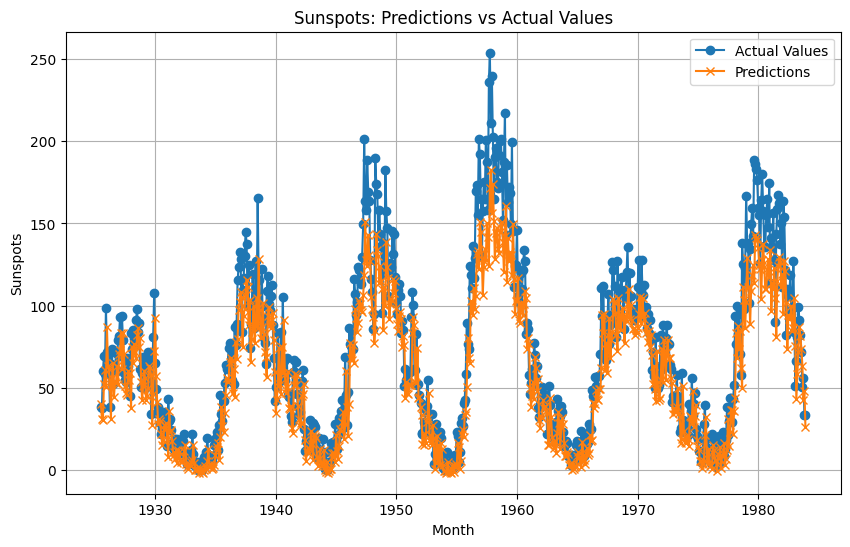

In [13]:

# Predicting values
predictions = model.predict(X_test)
predictions_trans = reverse_sequence(predictions, SEQ_LENGTH)


# # Inverse transform to get actual values
predictions_actual = scaler.inverse_transform(predictions_trans)
y_test_actual = scaler.inverse_transform(y_test)


# Align indices for plotting
test_start_index = split_index + SEQ_LENGTH
test_end_index = test_start_index + len(predictions)

# Slice the 'Month' column to match the length of predictions and y_test
months = data['Month'][test_start_index:test_end_index]

# Plotting predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(months, y_test_actual, label='Actual Values', marker='o')
plt.plot(months, predictions_actual, label='Predictions', marker='x')
plt.title('Sunspots: Predictions vs Actual Values')
plt.xlabel('Month')
plt.ylabel('Sunspots')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
mae = mean_absolute_error(y_test_actual, predictions_actual)
print(f'Mean Absolute Error (MAE): {mae}')

Mean Absolute Error (MAE): 16.937383973478017
